In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cltpoint/index.txt
/kaggle/input/cltpoint/pointSource/train_index.txt
/kaggle/input/cltpoint/pointSource/test_index.txt
/kaggle/input/cltpoint/pointSource/test/dualSource4376.T.CW
/kaggle/input/cltpoint/pointSource/test/singleSource200.txt
/kaggle/input/cltpoint/pointSource/test/dualSource4116.T.CW
/kaggle/input/cltpoint/pointSource/test/dualSource3876.txt
/kaggle/input/cltpoint/pointSource/test/dualSource3627.txt
/kaggle/input/cltpoint/pointSource/test/dualSource3788.txt
/kaggle/input/cltpoint/pointSource/test/singleSource221_P.mse
/kaggle/input/cltpoint/pointSource/test/dualSource4150.T.CW
/kaggle/input/cltpoint/pointSource/test/dualSource3635.txt
/kaggle/input/cltpoint/pointSource/test/dualSource4263.txt
/kaggle/input/cltpoint/pointSource/test/singleSource206.txt
/kaggle/input/cltpoint/pointSource/test/dualSource3650.txt
/kaggle/input/cltpoint/pointSource/test/dualSource4509.txt
/kaggle/input/cltpoint/pointSource/test/dualSource3808.txt
/kaggle/input/cltpoint/pointSour

## *FOR THE TEST!*

In [2]:
import torch
import os
print(torch.__version__)
print(os.path.exists("/kaggle/input/cltpoint/pointSource/test_index.txt"))
print(os.path.exists("/kaggle/input/cltpoint/pointSource/test/dualSource3613.T.CW"))
print(os.path.exists("/kaggle/working/model_save"))
# print(os.listdir("/kaggle/working"))
# print(os.listdir("/kaggle/input/mfcnn/model_save"))

1.9.1
True
True
False


# 项目文件

## 导包

In [3]:
import os
import torch
from torch import nn
from torch.utils import data
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Module
# from model.dataset import PointDataSet, labelWriter
# from dataset.indexGenerate import indexGenerator

## 读取 生成 数据

In [4]:
# define dataset
class PointDataSet(data.Dataset):
    def __init__(self, root_path, list_path):
        self.root_path = root_path
        self.list_path = list_path
        self.file_name = [line.strip() for line in open(list_path, "r")]
        self.files = []
        for name in self.file_name:
            energy_path = os.path.join(root_path, "%s.T.CW" % name)
            label_path = os.path.join(root_path, "%s.txt" % name)
            self.files.append({
                "energy": energy_path,
                "label": label_path,
                "name": name
            })

    def __getitem__(self, index):
        file = self.files[index]
        name = file["name"]  # 获取文件名列表
        energy_path = file["energy"]  # 获取T.CW透射文件的路径
        label_path = file["label"]  # 获取标签文件的路径

        # 读取T.CW文件
        pointEnergyList = energyReader(energy_path)
        # 将python数组再转化为numpy数组，便于转化为pytorch的张量
        pointEnergyList = np.asarray(pointEnergyList, dtype=np.float32)

        # 读取txt文件  使用with结构打开文件，会自动关闭文件
        pointLabelList = labelReader(label_path)
        pointLabelList = np.asarray(pointLabelList, dtype=np.float32)

        return pointEnergyList, pointLabelList

    def __len__(self):
        return len(self.files)

# 读取T.CW文件的内容： 节点的能量值并存入列表中
def energyReader(energy_path):
    pointEnergyList = []
    with open(energy_path, "r") as f:  # 使用with结构打开文件，会自动关闭文件
        lineStr = f.readline()
        while lineStr:
            lineStr = lineStr.strip()  # 去除字符串后面紧跟着的换行符
            if (lineStr.find("CountMeshVertex") != -1):  # 读取节点数量
                strList = lineStr.split(" ")
                pointNumber = int(strList[1])
                break
            lineStr = f.readline()

        lineStr = f.readline()
        while lineStr:
            lineStr = lineStr.strip()  # 去除字符串后面紧跟着的换行符
            if (lineStr.find("3DCWTransmittanceMeshVertex") != -1):  # 读取节点能量值
                count = 0
                lineStr = f.readline()
                while count < pointNumber:  # 按顺序读取节点能量
                    lineStr = lineStr.strip()
                    pointEnergyList.append(float(lineStr))
                    lineStr = f.readline()
                    count += 1
            if (lineStr.find("CountMeshFace") != -1):  # 读取三角网格面片透射信息
                break
            lineStr = f.readline()
    return pointEnergyList

# 生成节点能量文件(多源)
def energyWriter(energy_path, energy_list):
    point_num = len(energy_list)
    with open(energy_path, "w") as f:
        f.write("CountMeshVertex %d\n" % point_num)
        f.write("3DCWTransmittanceMeshVertex\n")
        for energy in energy_list:
            f.write("%e\n" % energy)
        f.write("CountMeshFace\n")


# 读取txt标签文件的内容：节点标签值 0-不是光源 1-是光源
def labelReader(label_path):
    pointLabelList = []
    with open(label_path, "r") as f:
        strList = f.readline().strip().split(" ")
        for str in strList:
            pointLabelList.append(1 if int(str)==1 else 0)
    return pointLabelList

# 生成节点标签文件(多源)
def labelWriter(label_path, label_list):
    with open(label_path, "w") as f:
        for label in label_list:
            f.write("%d " % label)
            
# 生成节点的预测标签文件(多源)
def prelabelWriter(label_path, label_list):
    with open(label_path, "w") as f:
        for label in label_list:
            f.write("%.3f " % label)

# 测试程序
if __name__ == '__main__':
    root_path = "/kaggle/input/cltpoint/pointSource/test"  # /content/drive/MyDrive/Colab Notebooks/mfcnn/singleSource
    list_path = "/kaggle/input/cltpoint/pointSource/test_index.txt"  #/content/drive/MyDrive/Colab Notebooks/mfcnn/index.txt
    dataset = PointDataSet(root_path, list_path)
    print("The length of dataset is ", len(dataset))
    dataloader = data.DataLoader(dataset, batch_size=64)
    for i, pointdata in enumerate(dataloader):
        energy, label = pointdata
        if i == 0:
            print(type(energy))
            print(energy.shape)
            print(energy)
            print(type(label))
            print(label.shape)
            print(label)
            break

The length of dataset is  948
<class 'torch.Tensor'>
torch.Size([64, 4626])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.6552e-05, 1.5539e-04,
         1.1165e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.8823e-05, 4.3838e-05,
         4.0482e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.4417e-06, 9.7702e-06,
         7.8588e-06],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.4185e-05, 1.0685e-04,
         9.2157e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8736e-06, 2.6655e-06,
         2.4195e-06],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3883e-04, 1.7176e-04,
         1.4013e-04]])
<class 'torch.Tensor'>
torch.Size([64, 4626])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


## 训练 测试网络

Using device:  cuda
Learning rate: 0.001
Epoch: 0, Total Loss: 0.063871
Epoch: 1, Total Loss: 0.063761
Epoch: 2, Total Loss: 0.063750
Epoch: 3, Total Loss: 0.063746
Epoch: 4, Total Loss: 0.063729
Epoch: 5, Total Loss: 0.063711
Epoch: 6, Total Loss: 0.063706
Epoch: 7, Total Loss: 0.063699
Epoch: 8, Total Loss: 0.063694
Epoch: 9, Total Loss: 0.063691
Epoch: 10, Total Loss: 0.063684
Epoch: 11, Total Loss: 0.063604
Epoch: 12, Total Loss: 0.063226
Epoch: 13, Total Loss: 0.063121
Epoch: 14, Total Loss: 0.062974
Epoch: 15, Total Loss: 0.062869
Epoch: 16, Total Loss: 0.062905
Epoch: 17, Total Loss: 0.062776
Epoch: 18, Total Loss: 0.062478
Epoch: 19, Total Loss: 0.062453
Epoch: 20, Total Loss: 0.062435
Epoch: 21, Total Loss: 0.062381
Epoch: 22, Total Loss: 0.062058
Epoch: 23, Total Loss: 0.061964
Epoch: 24, Total Loss: 0.061432
Epoch: 25, Total Loss: 0.060855
Epoch: 26, Total Loss: 0.060668
Epoch: 27, Total Loss: 0.060196
Epoch: 28, Total Loss: 0.059942
Epoch: 29, Total Loss: 0.059470
Epoch: 30

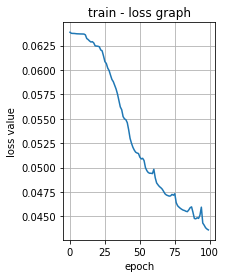

In [5]:
# prepare train and test data
# input = torch.rand([1, 4626], dtype=torch.float32)
batch_size = 128
root_path = "/kaggle/input/cltpoint/pointSource"
train_index = "/kaggle/input/cltpoint/pointSource/train_index.txt"
test_index = "/kaggle/input/cltpoint/pointSource/test_index.txt"
train_dataset = PointDataSet(os.path.join(root_path, "train"), train_index)  # 读取训练集和测试集
test_dataset = PointDataSet(os.path.join(root_path, "test"), test_index)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size)
test_files = [line.strip() for line in open("/kaggle/input/cltpoint/pointSource/test_index.txt", "r")]

# 设置训练设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # cpu or cuda(gpu)
print("Using device: ", device)

# define model contruct : MFCNN的输入为表面光子密度（光通量），输出为重建的CL源（源密度）
# MFCNN：七层全连接的神经网络结构：一层输入层一层输出层五层隐含层，每层的节点数都相同
class MFCNN_Model(Module):
    # 初始化方法
    def __init__(self, features):
        super(MFCNN_Model, self).__init__()
        self.sequential = nn.Sequential(
            # 对于MFCNN的每一层，神经元数量等于小鼠大脑中的节点数
            nn.Linear(in_features=features, out_features=features),
            nn.ReLU(),
#             nn.Dropout(p=0.2),
            nn.Linear(in_features=features, out_features=features),
            nn.ReLU(),
#             nn.Dropout(p=0.2),
            nn.Linear(in_features=features, out_features=features),
            nn.ReLU(),
#             nn.Dropout(p=0.2),
            # nn.Linear(in_features=features, out_features=features),
            # nn.ReLU(),
            # nn.Dropout(p=0.2),
            # nn.Linear(in_features=features, out_features=features),
            # nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(in_features=features, out_features=features),
            nn.ReLU()
#             nn.Dropout(p=0.2),
            # nn.Linear(in_features=features, out_features=features),
            # nn.ReLU(),  # nn.Sigmoid()
            # nn.Dropout(p=0.2)
        )

    # 前向过程
    def forward(self, x):
        y = self.sequential(x)
        return y

# 记录模型保存路径
model_path = "/kaggle/input/mfcnn/model_save/mfcnn_model_99.pth"

# 实例化对象
features = 4626  # 获取节点数
model = MFCNN_Model(features)

# 优化器设置：Adam优化算法
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)  # , betas=(0.9, 0.99)
# optim = torch.optim.SGD(params=model.parameters(), lr=0.0001)
# 损失函数设置：均方差损失函数
loss_fn = torch.nn.MSELoss(reduction="mean")
# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn.to(device)
start_epoch = -1

# 读取模型
if os.path.exists(model_path):
    print("---------------------------读取模型---------------------------")
    checkpoint = torch.load(model_path)  # 加载断点
    model.load_state_dict(checkpoint["network"])  # 加载模型可学习参数
#     optim.load_state_dict(checkpoint["optimizer"])  # 加载优化器参数
    start_epoch = checkpoint["epoch"]  # 加载epoch数
    # model = torch.load(model_path, map_location=torch.device("cpu"))
    print(checkpoint)

model.to(device)

# 打印当前学习率
print("Learning rate: %s" % str(optim.state_dict()['param_groups'][0]['lr']))
# 训练参数设置
EPOCH = start_epoch + 101
loss_list = []
# 训练过程
for epoch in range(start_epoch+1, EPOCH):
    # 开启训练模式
    model.train()
    total_loss = 0  # 记录在训练集上的总损失值
    for i, data in enumerate(train_dataloader):
        energys, labels = data
        energys = energys.to(device)
        labels = labels.to(device)
        # forword
        pre_labels = model(energys)
        loss = loss_fn(pre_labels, labels)
        # backword
        optim.zero_grad()
        loss.backward()
        #update
        optim.step()
        total_loss += loss.item()
    loss_list.append(total_loss)
    print("Epoch: {:d}, Total Loss: {:.6f}".format(epoch, total_loss))

    # 开启评估模式
    model.eval()
    # 避免计算梯度，减少训练过程所需的时间
    with torch.no_grad():
        index = 0
        for i, data in enumerate(test_dataloader):
            energys, labels = data
            energys = energys.to(device)
            labels = labels.to(device)
            # forword
            pre_labels = model(energys)
            # print(type(pre_labels))
            # print(pre_labels.topk(5))
            # 最后一轮循环输出预测标签txt文件
            if epoch==EPOCH-1:
                # print(pre_labels.topk(5))
                pre_labels = pre_labels.cpu().numpy().tolist()
                for label in pre_labels:
                    # label = label.tolist()
                    if not os.path.exists("/kaggle/working/predictLabel"):
                        os.mkdir("/kaggle/working/predictLabel")
                    label_path = os.path.join("/kaggle/working/predictLabel", "%s.txt" % test_files[index])
                    prelabelWriter(label_path, label)
                    index += 1

    # 训练结束，保存模型-方式2
    if epoch  == EPOCH - 1:
        print("---------------------------保存模型---------------------------")
        checkpoint = {
            "network": model.state_dict(),
            "optimizer": optim.state_dict(),
            "epoch": epoch
        }
        if not os.path.exists("/kaggle/working/model_save"):
            os.mkdir("/kaggle/working/model_save")
        torch.save(checkpoint, "/kaggle/working/model_save/mfcnn_model_%d.pth" % epoch)

# 可视化
plt.subplot(1, 2, 1)
plt.title("train - loss graph")
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.plot(loss_list)
plt.grid()
plt.show()
# singleSource53.T.CW
# singleSource53.T.CW